In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,ShuffleSplit,GridSearchCV
import gc
from scipy import sparse
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
import time
from datetime import timedelta, date
from fastai.tabular import *
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
test_df =  pd.read_csv('test.csv')

In [3]:
train = pd.DataFrame(train_df.groupby(['application_date', 'segment'])['case_count'].sum())
train.reset_index(inplace=True)

In [4]:
train1_dates = train[train['segment']==1]['application_date']
train2_dates = train[train['segment']==2]['application_date']

In [5]:
add_datepart(train, 'application_date', drop = False)
add_cyclic_datepart(train, 'application_date')

add_datepart(test_df, 'application_date', drop = False)
add_cyclic_datepart(test_df, 'application_date')

,id,segment,application_Year,application_Month,application_Week,application_Day,application_Dayofweek,application_Dayofyear,application_Is_month_end,application_Is_month_start,...,application_Is_year_start,application_Elapsed,application_weekday_cos,application_weekday_sin,application_day_month_cos,application_day_month_sin,application_month_year_cos,application_month_year_sin,application_day_year_cos,application_day_year_sin
0,1,1,2019,7,27,6,5,187,False,False,...,False,1562371200,-0.222521,-0.974928,0.528964,0.848644,-1.000000e+00,1.224647e-16,-0.998186,-0.060213
1,2,1,2019,7,27,7,6,188,False,False,...,False,1562457600,0.623490,-0.781831,0.347305,0.937752,-1.000000e+00,1.224647e-16,-0.997001,-0.077386
2,3,1,2019,7,28,8,0,189,False,False,...,False,1562544000,1.000000,0.000000,0.151428,0.988468,-1.000000e+00,1.224647e-16,-0.995521,-0.094537
3,4,1,2019,7,28,9,1,190,False,False,...,False,1562630400,0.623490,0.781831,-0.050649,0.998717,-1.000000e+00,1.224647e-16,-0.993747,-0.111659
4,5,1,2019,7,28,10,2,191,False,False,...,False,1562716800,-0.222521,0.974928,-0.250653,0.968077,-1.000000e+00,1.224647e-16,-0.991677,-0.128748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,176,2,2019,10,42,20,6,293,False,False,...,False,1571529600,0.623490,-0.781831,-0.758758,-0.651372,-1.836970e-16,-1.000000e+00,0.309017,-0.951057
176,177,2,2019,10,43,21,0,294,False,False,...,False,1571616000,1.000000,0.000000,-0.612106,-0.790776,-1.836970e-16,-1.000000e+00,0.325342,-0.945596
177,178,2,2019,10,43,22,1,295,False,False,...,False,1571702400,0.623490,0.781831,-0.440394,-0.897805,-1.836970e-16,-1.000000e+00,0.341571,-0.939856
178,179,2,2019,10,43,23,2,296,False,False,...,False,1571788800,-0.222521,0.974928,-0.250653,-0.968077,-1.836970e-16,-1.000000e+00,0.357698,-0.933837


In [6]:
from sklearn.preprocessing import LabelEncoder
cat_cols = ['application_Year', 'application_Month', 'application_Week',
       'application_Day', 'application_Dayofweek', 'application_Dayofyear',
       'application_Is_month_end', 'application_Is_month_start',
       'application_Is_quarter_end', 'application_Is_quarter_start',
       'application_Is_year_end', 'application_Is_year_start']
le = LabelEncoder()
for col in cat_cols:
    train[col] = train[col].astype(str)
    test_df[col] = test_df[col].astype(str)
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test_df[col] = le.transform(test_df[col])
    

In [7]:
train1 = train[train['segment']==1].reset_index(drop=True)
train2 = train[train['segment']==2].reset_index(drop=True)

test1 = test_df[test_df['segment']==1].reset_index(drop=True)
test2 = test_df[test_df['segment']==2].reset_index(drop=True)

In [8]:
train1_x = train1.drop(['segment', 'case_count'],axis = 1)
train1_y = train1['case_count']

train2_x = train2.drop(['segment', 'case_count'],axis = 1)
train2_y = train2['case_count']

In [9]:
train1_x = train1_x.drop(['application_Elapsed'], axis = 1)
test1 = test1.drop(['application_Elapsed'], axis = 1)

train2_x = train2_x.drop(['application_Elapsed'], axis = 1)
test2 = test2.drop(['application_Elapsed'], axis = 1)

In [36]:
train1_x_early = train1_x.iloc[:-87,:]
valid1_x_early = train1_x.iloc[-87:,:]

train1_y_early = train1_y.iloc[:-87]
valid1_y_early = train1_y.iloc[-87:]

train2_x_early = train2_x.iloc[:-93,:]
valid2_x_early = train2_x.iloc[-93:,:]

train2_y_early = train2_y.iloc[:-93]
valid2_y_early = train2_y.iloc[-93:]

In [11]:
#train1_x_early, valid1_x_early, train1_y_early, valid1_y_early = train_test_split(train1_x,train1_y,test_size = 0.2, random_state = 334)
train2_x_early, valid2_x_early, train2_y_early, valid2_y_early = train_test_split(train2_x,train2_y,test_size = 0.2, random_state = 334)

In [12]:
from lightgbm import LGBMRegressor

gbm1=LGBMRegressor(
        n_estimators=150,
        learning_rate=0.08,
        num_leaves=21,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.04,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=20,
        categorical_features = cat_cols
)

gbm1.fit(train1_x_early, train1_y_early)

LGBMRegressor(boosting_type='gbdt',
              categorical_features=['application_Year', 'application_Month',
                                    'application_Week', 'application_Day',
                                    'application_Dayofweek',
                                    'application_Dayofyear',
                                    'application_Is_month_end',
                                    'application_Is_month_start',
                                    'application_Is_quarter_end',
                                    'application_Is_quarter_start',
                                    'application_Is_year_end',
                                    'application_Is_year_start'],
              class_weight=None, colsample_bytree=0.9497036,
              importance_type='split', learning_rate=0.08, max_depth=8,
              min_child_samples=20, min_child_weight=20,
              min_split_gain=0.0222415, n_estimators=150, n_jobs=-1,
              num_leaves=21, objective

In [32]:
from lightgbm import LGBMRegressor

gbm2=LGBMRegressor(
        n_estimators=250,
        learning_rate=0.1,
        num_leaves=24,
        colsample_bytree=0.9497036,
        subsample=0.8715623,
        max_depth=8,
        reg_alpha=0.4,
        reg_lambda=0.073,
        min_split_gain=0.0222415,
        min_child_weight=20,
        categorical_features = cat_cols
)

gbm2.fit(train2_x_early, train2_y_early)

LGBMRegressor(boosting_type='gbdt',
              categorical_features=['application_Year', 'application_Month',
                                    'application_Week', 'application_Day',
                                    'application_Dayofweek',
                                    'application_Dayofyear',
                                    'application_Is_month_end',
                                    'application_Is_month_start',
                                    'application_Is_quarter_end',
                                    'application_Is_quarter_start',
                                    'application_Is_year_end',
                                    'application_Is_year_start'],
              class_weight=None, colsample_bytree=0.9497036,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=20,
              min_split_gain=0.0222415, n_estimators=250, n_jobs=-1,
              num_leaves=24, objective=

In [33]:
train1_pred_early = gbm1.predict(train1_x_early)
train1_pred_valid = gbm1.predict(valid1_x_early)

train2_pred_early = gbm2.predict(train2_x_early)
train2_pred_valid = gbm2.predict(valid2_x_early)

In [34]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
mape_train1 = mean_absolute_percentage_error(train1_y_early[:-1],train1_pred_early[:-1])
mape_train2 = mean_absolute_percentage_error(train2_y_early,train2_pred_early)

mape_valid1 = mean_absolute_percentage_error(valid1_y_early,train1_pred_valid)
mape_valid2 = mean_absolute_percentage_error(valid2_y_early,train2_pred_valid)

mape_train_total = (mape_train1+mape_train2)/2
mape_valid_total = (mape_valid1+mape_valid2)/2

print('Train1 mape: {}'.format(mape_train1))
print('Valid1 mape: {}'.format(mape_valid1))
print(' ')
print('Train2 mape: {}'.format(mape_train2))
print('Valid2 mape: {}'.format(mape_valid2))
print(' ')
print('Total mape train: {}'.format(mape_train_total))
print('Total mape valid: {}'.format(mape_valid_total))

Train1 mape: 229.8996165039327
Valid1 mape: 367.6150978469107
 
Train2 mape: 8.295503792551258
Valid2 mape: 20.137325554869395
 
Total mape train: 119.09756014824197
Total mape valid: 193.87621170089005


In [17]:
gbm2.feature_importances_

array([472,  80, 276, 369, 274, 519,  29,   0,   0,   0,   0,   0, 184, 166, 583, 536,  23,  55, 490, 682])

In [18]:
test1 = test1.drop(['segment','id'], axis = 1)
test1_pred = gbm1.predict(test1)

test2 = test2.drop(['segment','id'], axis = 1)
test2_pred = gbm2.predict(test2)

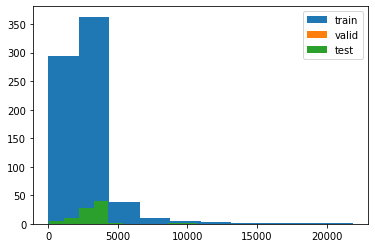

In [19]:
plt.hist(train1_y_early, label = 'train')
plt.hist(valid1_y_early, label = 'valid')
plt.hist(test1_pred, label = 'test')
plt.legend()

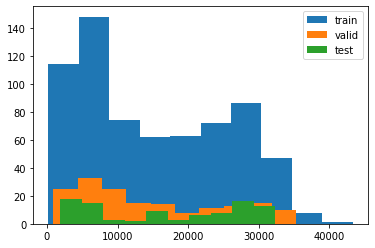

In [20]:
plt.hist(train2_y_early, label = 'train')
plt.hist(valid2_y_early, label = 'valid')
plt.hist(test2_pred, label = 'test')
plt.legend()

In [21]:
sub = pd.read_csv('sample_submission.csv')

In [22]:
sub['case_count'][sub['segment']==1] = test1_pred
sub['case_count'][sub['segment']==2] = test2_pred

C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
sub.to_csv('gbm_2models_1.csv',index = False)

In [24]:
sub1 = sub[['application_date','case_count']][sub['segment']==1]
sub1['application_date'] = pd.to_datetime(sub1['application_date'])
sub1 = sub1.set_index('application_date')

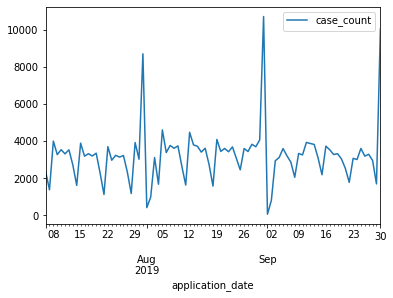

In [25]:
# plt.plot(sub1)
# plt.xticks(rotation=70)
sub1.plot()

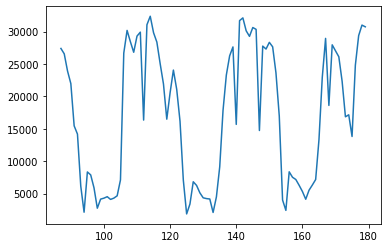

In [26]:
plt.plot(sub['case_count'][sub['segment']==2])

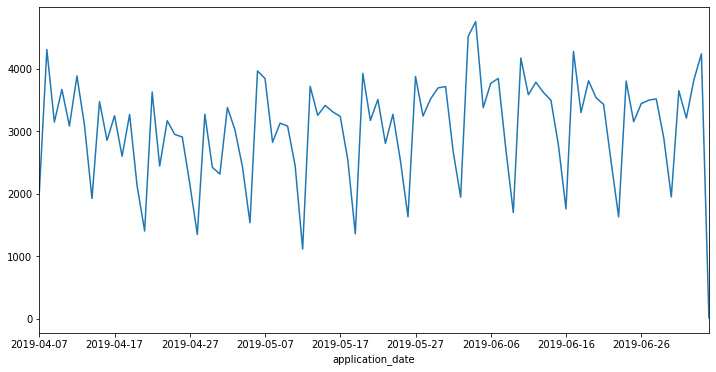

In [27]:
train1_y.index = train1_dates
plt.figure(figsize = (12,6))
train1_y[train1_y<6000][-90:].plot()

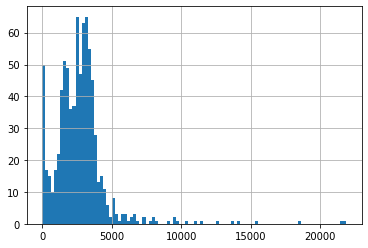

In [28]:
train1_y.hist(bins = 100)

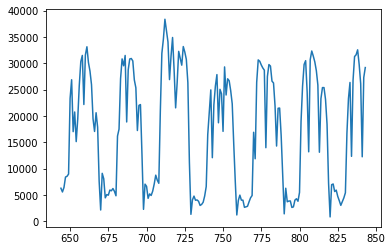

In [29]:
plt.plot(train2_y[-200:])

In [30]:
imp = gbm1.feature_importances_
features = train1_x_early.columns

importance_df = pd.DataFrame({'feature': features, 'importance': imp})

importance_df.sort_values(by = 'importance', ascending = False)

,feature,importance
14,application_day_month_cos,453
19,application_day_year_sin,438
15,application_day_month_sin,259
18,application_day_year_cos,230
5,application_Dayofyear,230
3,application_Day,214
0,application_Year,185
4,application_Dayofweek,145
2,application_Week,140
13,application_weekday_sin,94


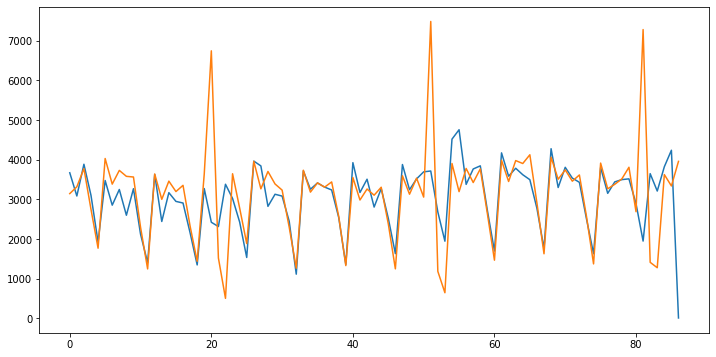

In [31]:
plt.figure(figsize = (12,6))
plt.plot(valid1_y_early.values)
plt.plot(train1_pred_valid)